### Investigation on use of Fourier Transform with Generative Models
- Fourier transform produces the spectrum of an image  
- Components for different frequencies are directly accessible 
- This allows a model to give importance to both overall structure and minute details 
- Question: is a VAE feasible in this domain?

Example: Input Image --> Input Spectrum --> VAE --> Output Spectrum --> Output Image

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and convert image to grayscale
img = Image.open('images/iris.png').convert('L')  # 'L' mode for grayscale
img_array = np.array(img)

# Apply 2D Fourier Transform
def fourier_transform(arr, direction='forward'):
    if direction == 'forward':
        fft = np.fft.fft2(arr)
        fft_shifted = np.fft.fftshift(fft)  # Shift zero-freq to center
        return fft_shifted
    elif direction == 'inverse':
        ifft_shifted = np.fft.ifftshift(arr)
        reconstructed_img = np.fft.ifft2(ifft_shifted).real
        return reconstructed_img
    
def visualize_fft(fft_shifted, mode='both'):
    if mode == 'spectrum':
        magnitude_spectrum = np.abs(fft_shifted)
        plt.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
        plt.title("Magnitude Spectrum")
        plt.axis('off')
        plt.show()

    elif mode == 'reconstruct':
        reconstructed_img = fourier_transform(fft_shifted, direction='inverse')
        plt.imshow(reconstructed_img, cmap='gray')
        plt.title("Reconstructed Image")
        plt.axis('off')
        plt.show()

    elif mode == 'both':
        reconstructed_img = fourier_transform(fft_shifted, direction='inverse')
        magnitude_spectrum = np.abs(fft_shifted)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(np.log(1 + magnitude_spectrum), cmap='gray')
        axs[0].set_title("Magnitude Spectrum")
        axs[0].axis('off')

        axs[1].imshow(reconstructed_img, cmap='gray')
        axs[1].set_title("Reconstructed Image")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()


# Inverse shift and inverse FFT
def extract_freq_range(fft_shifted, dx=0.1, dy=0.1, crop='box'):
    x= fft_shifted.shape[0]//2
    y= fft_shifted.shape[1]//2

    dx= int(dx * x)
    dy= int(dy * y)

    fft_shifted2 = fft_shifted.copy()
    fft_shifted2[:, :] = 0
    if crop=='box':
        fft_shifted2[x-dx:x+dx, y-dy:y+dy] = fft_shifted[x-dx:x+dx, y-dy:y+dy]
    elif crop=='plus':
        fft_shifted2[x-dx:x+dx, :] = fft_shifted[x-dx:x+dx, :]
        fft_shifted2[:, y-dy:y+dy] = fft_shifted[:, y-dy:y+dy]

    # fft_shifted2[x+dx1:x+dx2, y+dy1:y+dy2] = fft_shifted[x+dx1:x+dx2, y+dy1:y+dy2]
    # fft_shifted2[x-dx2:x-dx1, y-dy2:y-dy1] = fft_shifted[x-dx2:x-dx1, y-dy2:y-dy1] 
    return fft_shifted2



(521, 640)


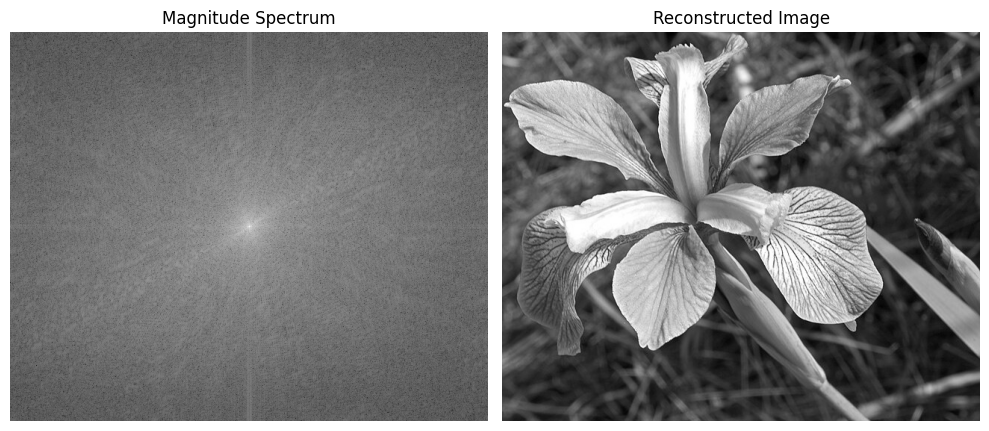

In [331]:
# Visualize the magnitude spectrum

fft_shifted = fourier_transform(img_array)
print(fft_shifted.shape)
visualize_fft(fft_shifted)

#### Visualizing contribution of various frequencies

Few low frequencies are sufficient to form the structure

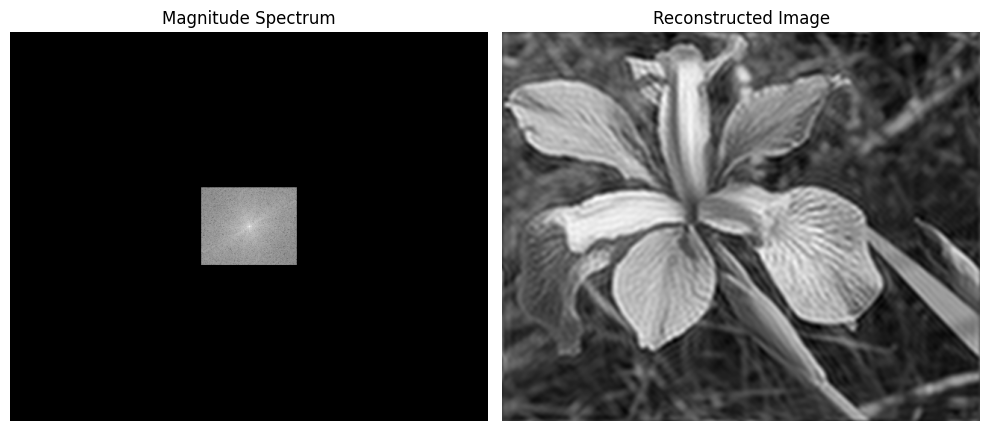

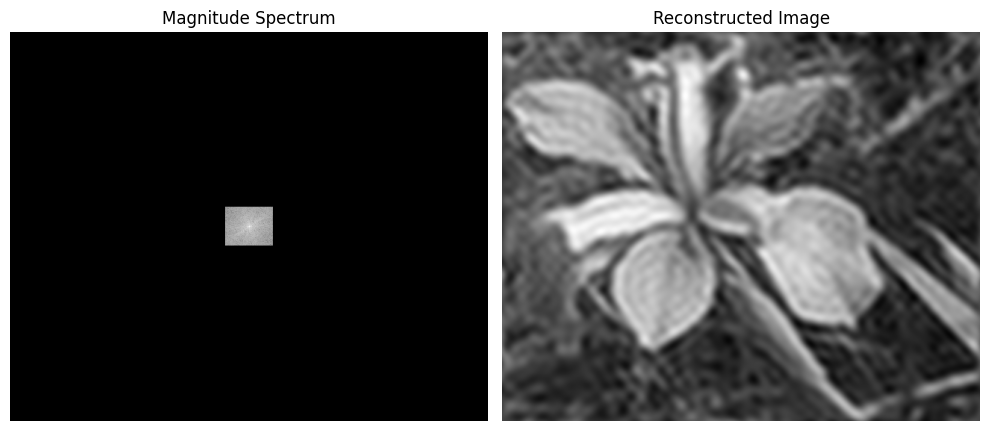

In [341]:

fft_shifted_20 = extract_freq_range(fft_shifted, dx=0.2, dy=0.2)
visualize_fft(fft_shifted_20)

fft_shifted_10 = extract_freq_range(fft_shifted, dx=0.1, dy=0.1)
visualize_fft(fft_shifted_10)

High frequencies add minute details
But this also covers more area in the spectrum than the low frequencies

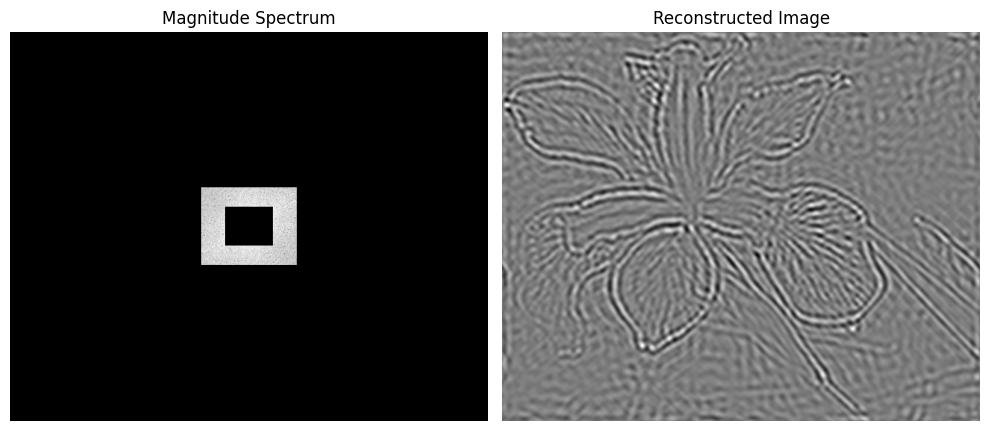

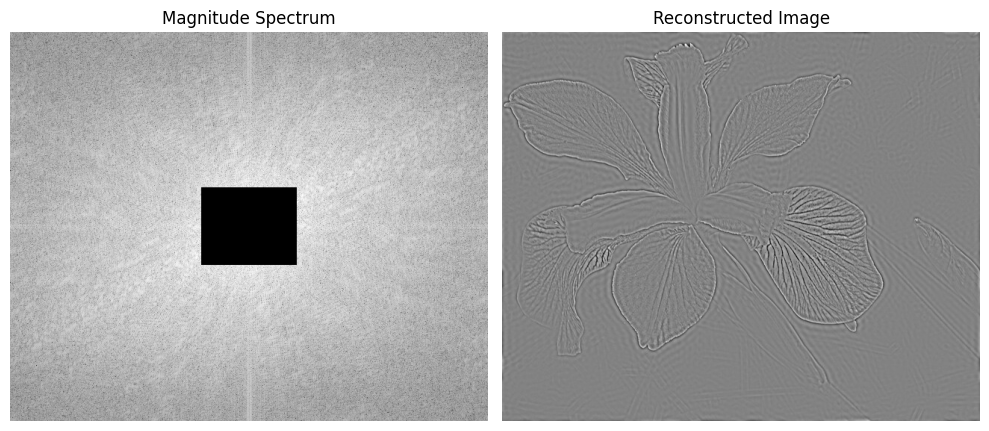

In [333]:

fft_shifted_10_20 = fft_shifted_20 - fft_shifted_10
visualize_fft(fft_shifted_10_20)

fft_shifted_20_100 = fft_shifted - fft_shifted_20
visualize_fft(fft_shifted_20_100)


#### Contribution of real and imaginary components

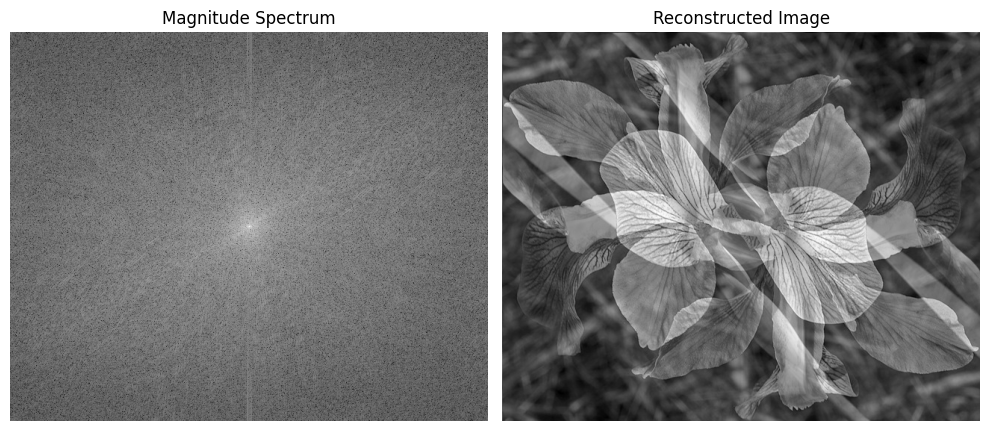

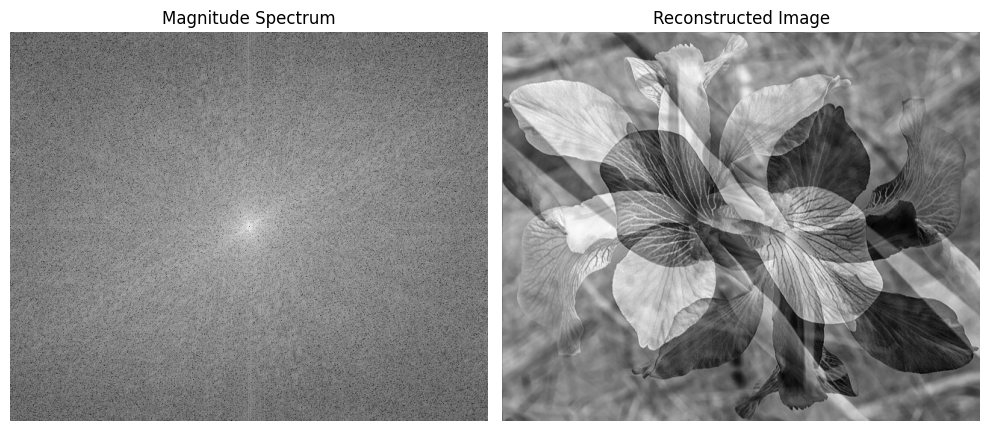

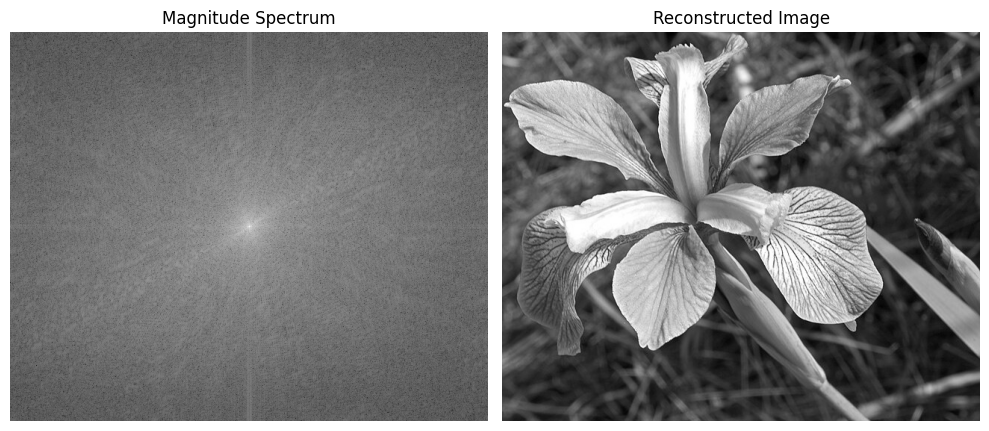

In [334]:
import cv2


fft_shifted_real = fourier_transform(img_array).real
visualize_fft(fft_shifted_real)

fft_shifted_imag = fourier_transform(img_array).imag
visualize_fft(1j*fft_shifted_imag)

visualize_fft(fft_shifted_real + 1j * fft_shifted_imag)


- Real part introduces cosine terms which are even  
- Imaginary part introduces sine terms which are odd

#### Comparing Spectrum of Blurred Image

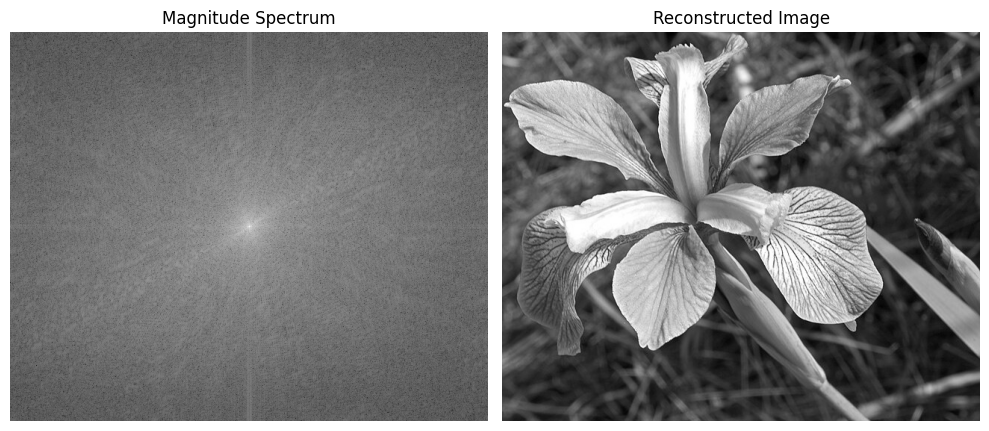

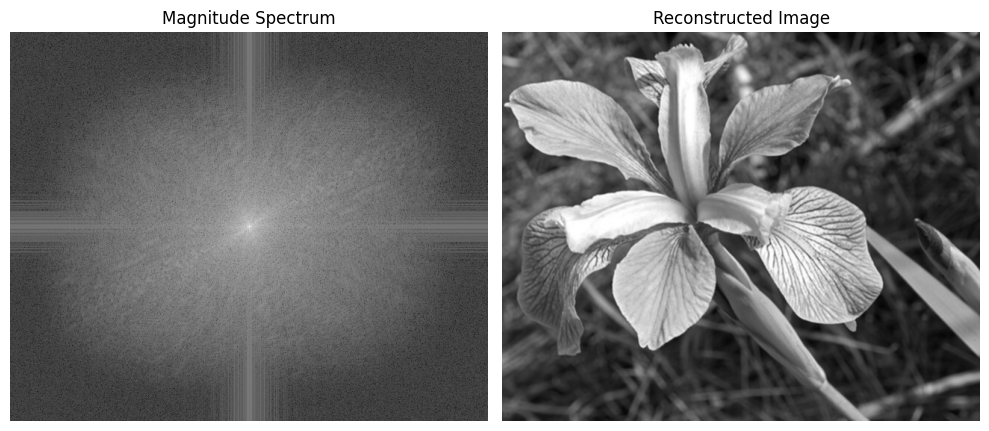

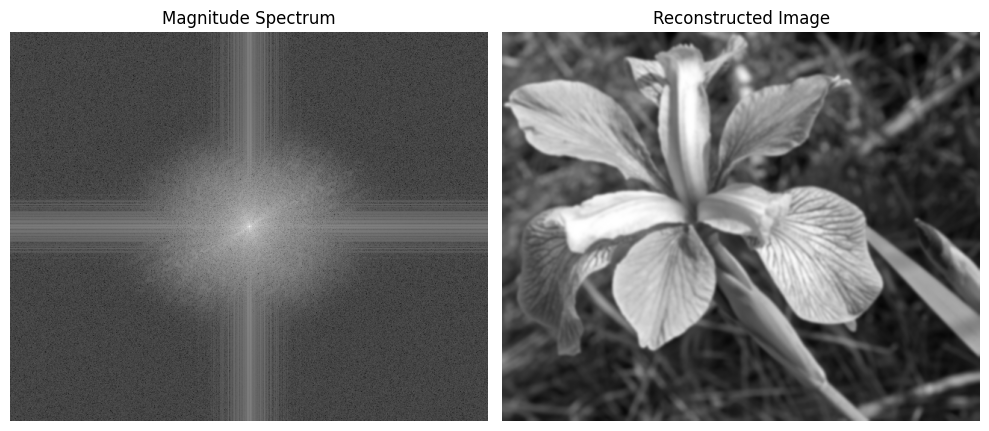

In [335]:
import cv2

visualize_fft(fft_shifted)

blurred_img_3 = cv2.GaussianBlur(img_array, (3, 3), sigmaX=0)
fft_shifted_blurred_img_3 = fourier_transform(blurred_img_3)
visualize_fft(fft_shifted_blurred_img_3)

blurred_img_9 = cv2.GaussianBlur(img_array, (9, 9), sigmaX=0)
fft_shifted_blurred_img_9 = fourier_transform(blurred_img_9)
visualize_fft(fft_shifted_blurred_img_9)



- With greater kernel size of gaussian blur, more high-frequency terms are subdued.  
- Also, the spectrum plot confirms that high-frequencies (corresponding to for sharp details)  
 cover a larger area than low-frequencies in the spectrum.

#### Checking sensitivity of images to minor changes in spectrum

Since a model like VAE will have some error, 
The aim is to understand if the resulting image is robust to some noise in the generated spectrum.

1. Blurring
2. Shifting of spectrum map by 1 pixel

In [336]:
# sanity test for real/imag operations
# a = img_array.astype(np.float64) + 1j * img_array.astype(np.float64)
# a_complex = blur_complex_arr(a)
# print(a.dtype, a_complex.dtype, img_array.astype(np.float64).dtype)
# a_img = a_complex.real
# print(( cv2.GaussianBlur(img_array.astype(np.float64), (3, 3), sigmaX=0) -a_img))

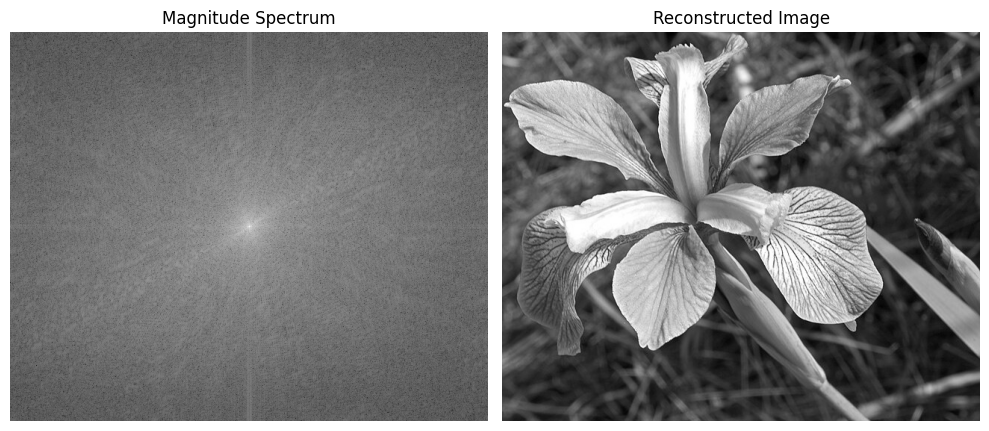

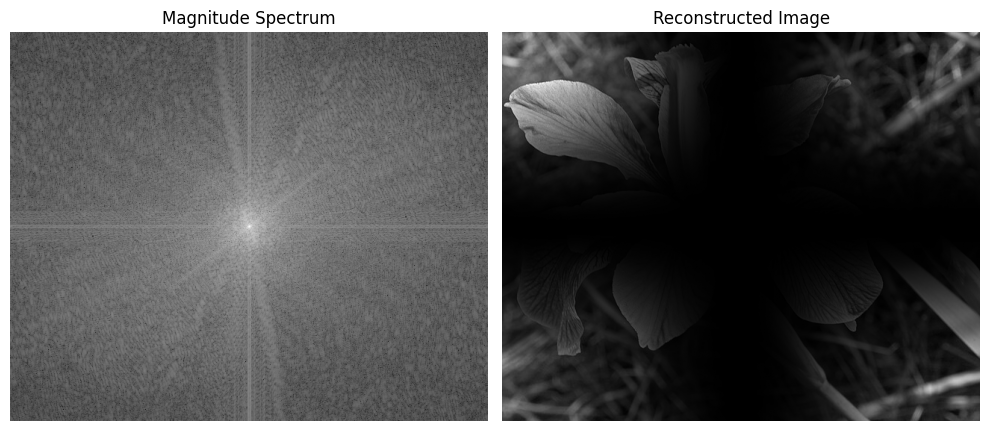

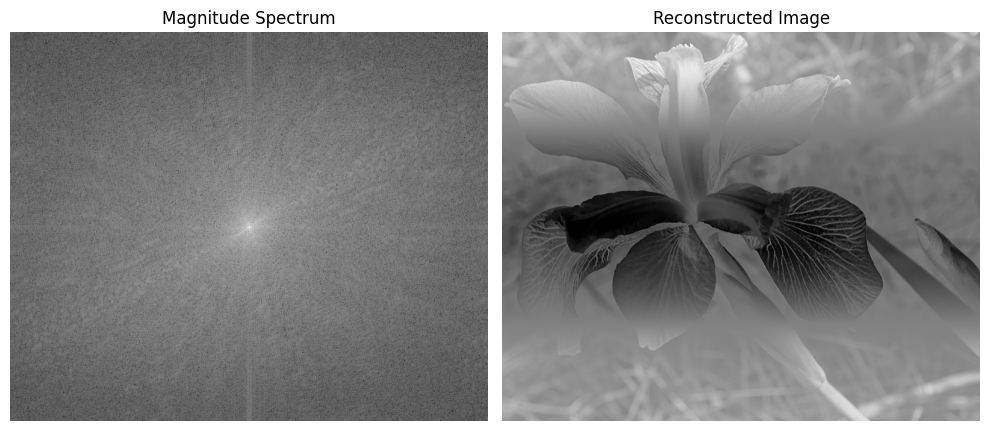

In [337]:
def blur_complex_arr(arr,k=3):
    real_blur = cv2.GaussianBlur(arr.real, (k, k), sigmaX=0)
    imag_blur = cv2.GaussianBlur(arr.imag, (k, k), sigmaX=0)
    return real_blur + 1j * imag_blur

def shift_complex_arr(arr, dx=1, dy=0):
    arr2 = arr.copy()
    W, H = arr.shape
    arr2[dx:, dy:] = arr[:W-dx, :H-dy]
    return arr2

visualize_fft(fft_shifted)
visualize_fft(blur_complex_arr(fft_shifted)) # blur 3x3 gaussian
visualize_fft(shift_complex_arr(fft_shifted)) # shift spectrum map by 1 pixel

- Minor changes in spectrum have drastic changes to images.  
- For lower frequencies a shift by 1 location is very drastic (eg: frequency 3 to 4)  
- For higher frequencies a shift by 1 location is not very drastic (eg: frequency 200 to 201)

We are more concerned about high frequencies for high quality image generation.
Trying after masking low frequencies:

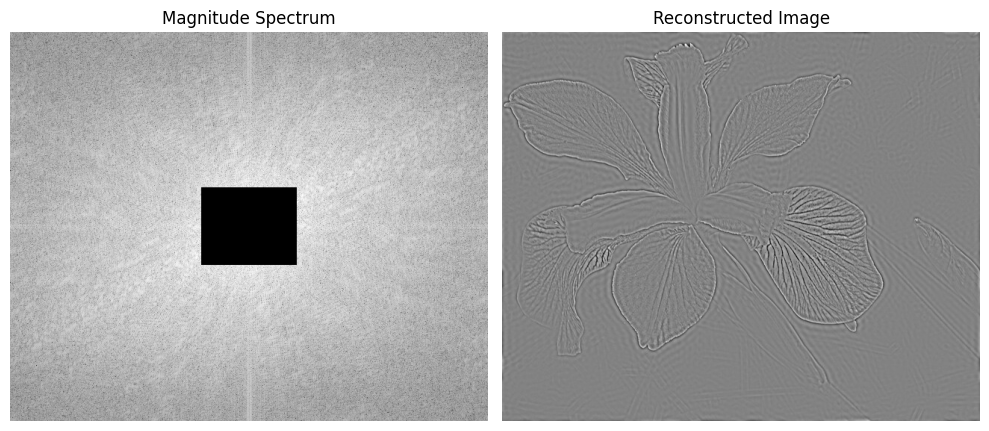

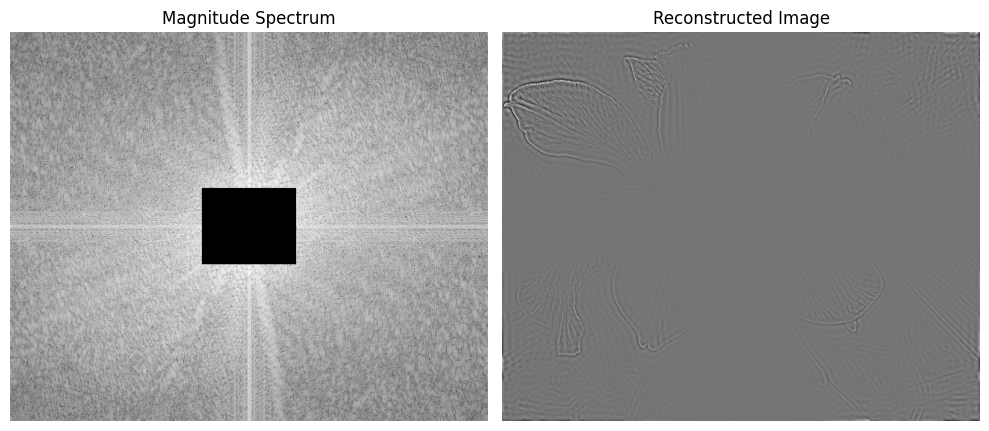

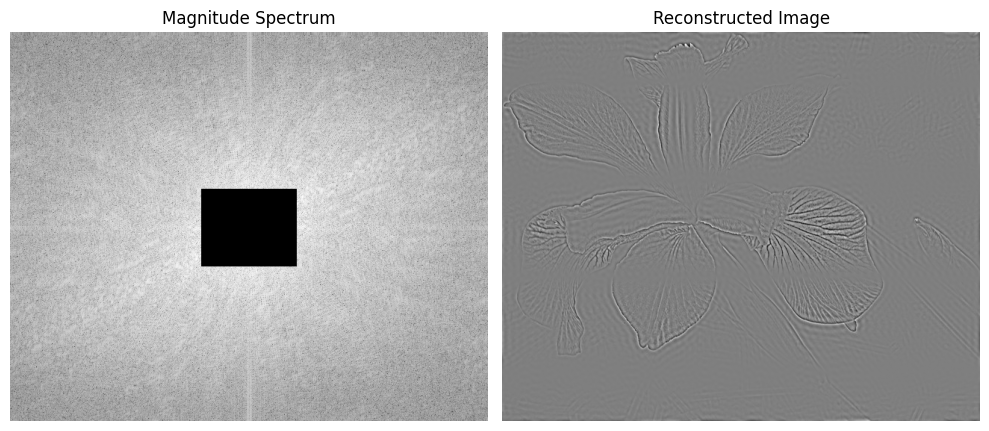

In [338]:
visualize_fft(fft_shifted_20_100)
visualize_fft(blur_complex_arr(fft_shifted_20_100)) # blur 3x3 gaussian
visualize_fft(shift_complex_arr(fft_shifted_20_100, 2,0) ) # shift spectrum map by 2 pixel

#### Conclusion
- **The image is very sensitive even to small changes in spectrum.**
- **The proposed idea of a generative model in this space is not feasible**.

#### VAE Attempt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# FFT preprocessing
def fft2d(img):
    fft = np.fft.fft2(img)
    fft = np.fft.fftshift(fft)
    return np.stack([fft.real, fft.imag], axis=0)  # shape (2, 28, 28)

def ifft2d(fft_tensor):
    fft_combined = fft_tensor[0] + 1j * fft_tensor[1]
    fft_unshifted = np.fft.ifftshift(fft_combined)
    return np.fft.ifft2(fft_unshifted).real

# Custom dataset
class FFTMNIST(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(root='./data', train=train, download=True, transform=transforms.ToTensor())

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, _ = self.mnist[idx]
        img_np = img.squeeze().numpy()
        fft = fft2d(img_np).astype(np.float32)
        return torch.tensor(fft)

# VAE model
class ComplexVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ComplexVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1),  # 2x28x28 -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 32x7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 32 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Train loop
def train(model, dataloader, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.2f}")

# Inverse visualize
def visualize_ifft(recon_fft):
    img = ifft2d(recon_fft.cpu().numpy())
    plt.imshow(img, cmap='gray')
    plt.title("Reconstructed Image from FFT VAE Output")
    plt.axis('off')
    plt.show()

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 16
batch_size = 64
epochs = 20

# Setup
train_ds = FFTMNIST(train=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
model = ComplexVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
train(model, train_loader, optimizer, device, epochs=epochs)


Epoch 1, Loss: 24188.65
Epoch 2, Loss: 15905.00
Epoch 3, Loss: 14963.99
Epoch 4, Loss: 14448.01
Epoch 5, Loss: 14110.84
Epoch 6, Loss: 13873.49
Epoch 7, Loss: 13693.29
Epoch 8, Loss: 13543.12
Epoch 9, Loss: 13411.50
Epoch 10, Loss: 13306.54
Epoch 11, Loss: 13217.50
Epoch 12, Loss: 13139.91
Epoch 13, Loss: 13078.45
Epoch 14, Loss: 13024.97
Epoch 15, Loss: 12973.89
Epoch 16, Loss: 12934.11
Epoch 17, Loss: 12894.36
Epoch 18, Loss: 12861.25
Epoch 19, Loss: 12827.96
Epoch 20, Loss: 12797.38


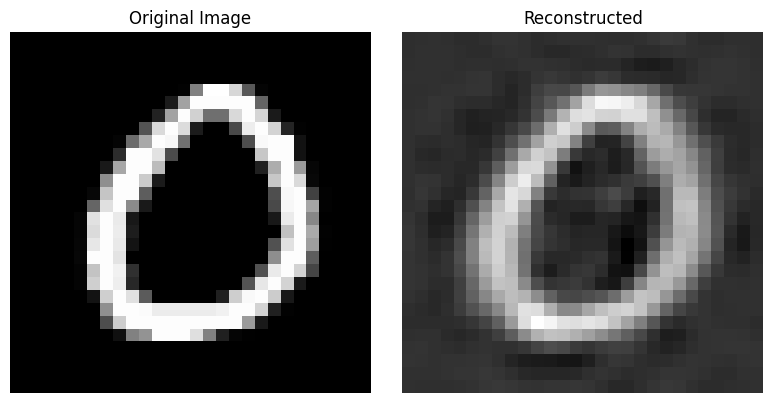

In [7]:
def visualize_comparison(orig_fft, recon_fft):
    orig_img = ifft2d(orig_fft.cpu().numpy())
    recon_img = ifft2d(recon_fft.cpu().numpy())
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_img, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(recon_img, cmap='gray')
    axs[1].set_title("Reconstructed")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for batch in train_loader:
        sample_fft = batch[0].unsqueeze(0).to(device)
        recon_fft, _, _ = model(sample_fft)
        visualize_comparison(sample_fft.squeeze(0), recon_fft.squeeze(0))
        break

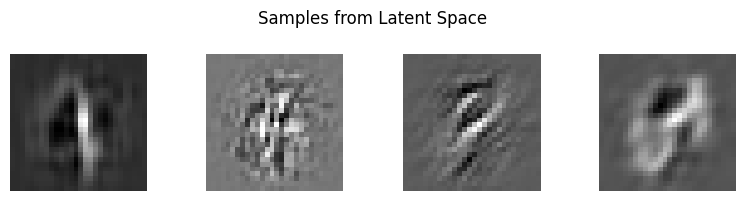

In [11]:
def sample_and_visualize(model, device, n_samples=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.fc_mu.out_features).to(device)
        recon_fft = model.decode(z).cpu()

        fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 2, 2))
        for i in range(n_samples):
            fft_img = recon_fft[i]
            img = ifft2d(fft_img.numpy())
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
        plt.suptitle("Samples from Latent Space")
        plt.tight_layout()
        plt.show()

sample_and_visualize(model, device, n_samples=4)